In [50]:
import numpy as np
import pandas as pd
import janitor
import os
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from datetime import date




In [2]:
ice = pd.read_excel('data/2025-ICLI-00019_2024-ICFO-39357_ERO_Encounters_raw.xlsx', 
                    sheet_name=1, 
                    skiprows=6)

In [3]:
ice.shape

(700247, 25)

In [52]:
ice_clean = ice.clean_names()
ice_clean.head()

,event_date,responsible_aor,responsible_site,lead_event_type,lead_source,event_type,final_program,final_program_group,encounter_criminality,processing_disposition,...,final_order_date,birth_date,birth_year,citizenship_country,gender,event_landmark,alien_file_number,eid_case_id,eid_subject_id,unique_identifier
0,2024-08-03,HQ Area of Responsibility,ERO - Pacific Enforcement Response Center,Not applicable,NaN,CAP Local,ERO Criminal Alien Program,ICE,3 Other Immigration Violator,Prosecutorial Discretion,...,NaT,"(b)(6), (b)(7)(c)",2006.0,HONDURAS,Male,NaN,"(b)(6), (b)(7)(c)",NaN,"(b)(6), (b)(7)(C), (6)(7)(E)",000080c6fa4a6ecd0b3beed3c559582c4205c50a
1,2024-10-18,Seattle Area of Responsibility,"PORTLAND, OR, DOCKET CONTROL OFFICE",Not applicable,NaN,CAP Local,ERO Criminal Alien Program,ICE,3 Other Immigration Violator,Not in Custody,...,NaT,"(b)(6), (b)(7)(c)",2006.0,HONDURAS,Unknown,NaN,"(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",000080c6fa4a6ecd0b3beed3c559582c4205c50a
2,2024-11-21,Seattle Area of Responsibility,"PORTLAND, OR, DOCKET CONTROL OFFICE",Not applicable,NaN,CAP Local,ERO Criminal Alien Program,ICE,3 Other Immigration Violator,Warrant of Arrest/Notice to Appear,...,NaT,"(b)(6), (b)(7)(c)",2006.0,HONDURAS,Unknown,NaN,"(b)(6), (b)(7)(c)",NaN,"(b)(6), (b)(7)(C), (6)(7)(E)",000080c6fa4a6ecd0b3beed3c559582c4205c50a
3,2025-02-16,HQ Area of Responsibility,ERO - Pacific Enforcement Response Center,Not applicable,NaN,CAP Local,ERO Criminal Alien Program,ICE,3 Other Immigration Violator,Not in Custody,...,NaT,"(b)(6), (b)(7)(c)",2002.0,MEXICO,Male,NaN,"(b)(6), (b)(7)(c)",NaN,"(b)(6), (b)(7)(C), (6)(7)(E)",0000ad75abb300f8b89ada314a02a508fb886ad8
4,2025-03-20,New York City Area of Responsibility,"VARRICK, NY, SERVICE PROCESSING CENTER (DOCKET...",Not applicable,NaN,CAP Local,ERO Criminal Alien Program,ICE,2 Pending Criminal Charges,Detainer,...,NaT,"(b)(6), (b)(7)(c)",1980.0,VENEZUELA,Male,CAP - QUEENS CENTRAL BOOKING NY State,"(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",0000b05116e18fc26472d546d43da50f24133e9c


### Per column, check missingness and unsual values

I replaced missing values (for character columns) with "Not applicable" or "Unknown", depending on what I thought made the most sense given my understanding of the variable. For columns in which the percentage of missing values was very low (i.e. < 1%), I dropped them. 


**Event Date**: Date of encounter

In [53]:

# unsual observation with event date at 2115-01-21
print(ice_clean.event_date.sort_values().tail(5))
print(ice_clean.event_date.sort_values().head(5))

ice_clean[ice_clean['event_date']=='2115-01-21']

# remove observation
ice_clean = ice_clean[ice_clean['event_date']!='2115-01-21']

280012   2025-06-27
553660   2025-06-27
582544   2025-06-27
700246   2025-06-27
482710   2115-01-21
Name: event_date, dtype: datetime64[ns]
128980   2024-08-01
148754   2024-08-01
489094   2024-08-01
328689   2024-08-01
84537    2024-08-01
Name: event_date, dtype: datetime64[ns]


**Responsible AOR**: Area of Responsibility (ICE field office)

In [54]:


# relatively small proportion of missing values of responsible AOR
print(ice_clean['responsible_aor'].isna().sum() / ice_clean.shape[0])

ice_clean = ice_clean.dropna(subset='responsible_aor')

# Remove HQ Area of Responsibility because it is not included in ICE's list of field offices of the areas of responsibility map
ice_clean=ice_clean[ice_clean["responsible_aor"] != 'HQ Area of Responsibility']
print(ice_clean['responsible_aor'].unique())

0.001470911651048346
['Seattle Area of Responsibility' 'New York City Area of Responsibility'
 'Washington Area of Responsibility' 'Houston Area of Responsibility'
 'Newark Area of Responsibility' 'St. Paul Area of Responsibility'
 'Miami Area of Responsibility' 'San Francisco Area of Responsibility'
 'New Orleans Area of Responsibility' 'Dallas Area of Responsibility'
 'Denver Area of Responsibility' 'Buffalo Area of Responsibility'
 'Atlanta Area of Responsibility' 'Chicago Area of Responsibility'
 'San Diego Area of Responsibility' 'Boston Area of Responsibility'
 'El Paso Area of Responsibility' 'Harlingen Area of Responsibility'
 'Phoenix Area of Responsibility' 'Salt Lake City Area of Responsibility'
 'Philadelphia Area of Responsibility' 'Detroit Area of Responsibility'
 'San Antonio Area of Responsibility' 'Baltimore Area of Responsibility'
 'Los Angeles Area of Responsibility']


In [55]:
# for ease of merging with AOR shapefile:
ice_clean = (
    ice_clean
    .rename(columns={"responsible_aor": "aor"})
    .assign(aor=lambda df: df["aor"].str.replace(" Area of Responsibility", "", regex=False))
)

In [56]:
conditions = [
    ice_clean["aor"] == "St. Paul",
    ice_clean["aor"] == "Washington",
    (ice_clean["aor"] == "HQ") & (ice_clean["responsible_site"] == "ERO - Pacific Enforcement Response Center"),
    (ice_clean["aor"] == "HQ") & (ice_clean["responsible_site"] == "WASHINGTON, DC, (HQ) DOCKET CONTROL OFFICE")

]

replacements = [
    "St Paul", 
    "DC",
    "Los Angeles",
    "DC"
]

ice_clean["aor"] = np.select(conditions, replacements, default=ice_clean["aor"])

In [57]:
ice_clean.head()

,event_date,aor,responsible_site,lead_event_type,lead_source,event_type,final_program,final_program_group,encounter_criminality,processing_disposition,...,final_order_date,birth_date,birth_year,citizenship_country,gender,event_landmark,alien_file_number,eid_case_id,eid_subject_id,unique_identifier
1,2024-10-18,Seattle,"PORTLAND, OR, DOCKET CONTROL OFFICE",Not applicable,NaN,CAP Local,ERO Criminal Alien Program,ICE,3 Other Immigration Violator,Not in Custody,...,NaT,"(b)(6), (b)(7)(c)",2006.0,HONDURAS,Unknown,NaN,"(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",000080c6fa4a6ecd0b3beed3c559582c4205c50a
2,2024-11-21,Seattle,"PORTLAND, OR, DOCKET CONTROL OFFICE",Not applicable,NaN,CAP Local,ERO Criminal Alien Program,ICE,3 Other Immigration Violator,Warrant of Arrest/Notice to Appear,...,NaT,"(b)(6), (b)(7)(c)",2006.0,HONDURAS,Unknown,NaN,"(b)(6), (b)(7)(c)",NaN,"(b)(6), (b)(7)(C), (6)(7)(E)",000080c6fa4a6ecd0b3beed3c559582c4205c50a
4,2025-03-20,New York City,"VARRICK, NY, SERVICE PROCESSING CENTER (DOCKET...",Not applicable,NaN,CAP Local,ERO Criminal Alien Program,ICE,2 Pending Criminal Charges,Detainer,...,NaT,"(b)(6), (b)(7)(c)",1980.0,VENEZUELA,Male,CAP - QUEENS CENTRAL BOOKING NY State,"(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",0000b05116e18fc26472d546d43da50f24133e9c
5,2024-08-06,DC,"ERO - Harrisonburg, VA Sub Office",Not applicable,NaN,Alternatives to Detention,ERO Criminal Alien Program,ICE,1 Convicted Criminal,Other,...,1999-10-18,"(b)(6), (b)(7)(c)",1981.0,HONDURAS,Male,"HBG GENERAL AREA, NON-SPECIFIC","(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",0000b34edd657d516c02b13a7c352d62d0effcb6
6,2024-10-19,Houston,"ERO - Montgomery County, TX Sub Office",Not applicable,NaN,ERO Criminal Alien Program,ERO Criminal Alien Program,ICE,1 Convicted Criminal,REINSTATEMENT OF DEPORT ORDER I-871,...,2023-10-10,"(b)(6), (b)(7)(c)",1984.0,MEXICO,Male,"HARRIS COUNTY JAIL, HOUSTON, TX","(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",0000ba6e459998a6046d185d82cf4349de1479d0


**Responsible Site**: Docket control office, which is a sub-office within an area of responsibility


In [58]:
print(ice_clean['responsible_site'].unique())

# no missing values within existing subset
print(ice_clean['responsible_site'].isna().sum() / ice_clean.shape[0])



['PORTLAND, OR, DOCKET CONTROL OFFICE'
 'VARRICK, NY, SERVICE PROCESSING CENTER (DOCKET CONTROL OFFICE)'
 'ERO - Harrisonburg, VA Sub Office'
 'ERO - Montgomery County, TX Sub Office'
 'ICE ERO - MOUNT LAUREL NJ SUB-OFC' 'ST. PAUL, MN, DOCKET CONTROL OFFICE'
 'ERO - Bradenton, FL Sub Office'
 'SAN FRANCISCO, CA, DOCKET CONTROL OFFICE'
 'NEW ORLEANS, LA, DOCKET CONTROL OFFICE'
 'DALLAS, TX, DOCKET CONTROL OFFICE' 'ERO - Frederick, CO, Sub office'
 'ERO - Central Islip, NY Sub Office' 'BATAVIA CMD CTR NY DCO'
 'ERO - Stuart, FL Sub Office' 'ERO - Charlotte, NC Sub-Office'
 'CHICAGO, IL, DOCKET CONTROL OFFICE' 'TAMPA, FL, DOCKET CONTROL OFFICE'
 'ORLANDO, FL, DOCKET CONTROL OFFICE'
 'SAN DIEGO, CA, DOCKET CONTROL OFFICE' 'ERO - Manchester, NH Sub-Office'
 'ERO - Charleston, SC Sub-Office' 'ERO - Pecos, TX IHP Sub-Office'
 'HARLINGEN, TX, DOCKET CONTROL OFFICE' 'ERO - El Paso, TX SPC Sub-Office'
 "Jacksonville Sheriff's Office" 'ERO - Birmingham, AL Sub Office'
 'ERO - Savannah, GA Sub-Off

**Lead event type**: unknown

In [59]:
# no missing values, and 'Not Applicable' seems to mean something
print(ice_clean['lead_event_type'].unique())
print(ice_clean[ice_clean['lead_event_type']=='Not applicable'].shape[0])

['Not applicable' 'CAP Federal' 'CAP Local' 'Alternatives to Detention'
 '287(g) Program Activities (Lead)' 'Non-Detained Docket Control'
 'Fugitive Operations (Lead)' 'CAP State' 'ERO Criminal Prosecutions'
 'Joint Criminal Alien Response Team' 'Detained Docket Control']
406045


**Lead source**: Unknown


In [60]:
print(ice_clean['lead_source'].unique())

print(ice_clean['lead_source'].isna().sum() / ice_clean.shape[0])

ice_clean['lead_source'] = ice_clean['lead_source'].fillna('Not applicable')

[nan 'BOP Referral (Bureau of Prisons)'
 'LEA Referral (Local Enforcement Agency)' 'Other Lead'
 'Priority Enforcement Program' 'Other Agency Referral'
 'National Security Referral' 'USMS Referral (US Marshals Service)'
 'Follow-up Investigation' 'DEA Referral (Drug Enforcement Agency)'
 'GAP(General Administrative Plan) special' 'Deportations Referral'
 'FBI Referral (Federal Bureau of Investigation)'
 'Foreign Fugitive Referral'
 'DOL(Department of Labor) Referral Using Form ESA-91'
 'Anonymous Complaint' 'Link Analysis' 'Visual Surveillance'
 'CIS Criminal Referral to ERO' 'Joint Effort' 'ATF Referral'
 'Written, Signed Complaint' 'Inspections Referral' 'Customs Referral'
 'Foreign Local Enforcement Agency Referral'
 'DOI Referral (Department of the Interior)' 'Coast Guard Referral'
 'TECS Case Management number' 'National Targeting Plan' 'Informant'
 'DOL(Department of Labor) Referral Using Form Other Than ESA-91'
 'Non-Visual Surveillance' 'Dept of State Referral' 'Private Citizen

**Event Type**: roughly tracks the "Apprehension method" field in the arrests data, though many encounters do not result in arrests.

In [61]:
print(ice_clean['event_type'].unique())

# no actual NAs for current subset of data
print(ice_clean['event_type'].isna().sum() / ice_clean.shape[0])

['CAP Local' 'Alternatives to Detention' 'ERO Criminal Alien Program'
 'CAP Federal' 'Non-Detained Docket Control'
 'Administrative Non-Criminal Individual' 'Fugitive Operations (Event)'
 '287(g) Program Activities' 'Criminal Alien'
 'Administrative Criminal Alien' 'Fugitive Operations (Lead)' 'CAP State'
 'Assault' 'ERO Reprocessed' 'Probation and Parole (Event)'
 'ERO Criminal Prosecutions' 'Detained Docket Control'
 'Criminal Individual' 'OCDETF' 'U.S. Marshals' 'Not applicable'
 'Criminal Alien Smuggling' 'Administrative Alien Smuggling'
 'Worksite Investigation' 'Criminal Sanctions' 'Undocumented Alien'
 'Administrative Miscellaneous (Private Bill, Citation, etc)'
 'Criminal Organization' 'Unknown' 'Joint Criminal Alien Response Team'
 'Criminal Contraband Smuggling' 'Criminal Fraud' 'Human Trafficking'
 'GITMO Processing' 'ARO Waiver Submission' 'Administrative Fraud'
 'Administrative Seizure' 'Administrative Regulatory'
 'Administrative Sanctions' 'Mass Migration'
 '287(g) Progr

In [62]:
# 0.2% is 'Not applicable'
print(ice_clean[ice_clean['event_type']=='Not applicable'].shape[0]/ ice_clean.shape[0])

0.0003060732224442886


**Final Program**: The program associated with the arrest (not necessarily performed by ICE), which might also be described as the category of arrest. The values show the range of these categories, but key examples are the criminal alien program, which involves arrests in prisons and jails, the 287(g) program, which involves collaboration with a local agency, and border patrol.

In [63]:
print(ice_clean['final_program'].unique())

# no NAs
print(ice_clean['final_program'].isna().sum() / ice_clean.shape[0])

['ERO Criminal Alien Program' 'Fugitive Operations'
 'Non-Detained Docket Control' 'Alternatives to Detention'
 'Detention and Deportation' 'Detained Docket Control' '287G Program'
 'Mobile Criminal Alien Team' 'Juvenile' 'ERO Criminal Prosecutions'
 'Law Enforcement Area Response Units' '287g Task Force'
 'Violent Criminal Alien Section']
0.0


**Encounter Criminality**: This takes three values, corresponding to whether an individual has at least one criminal conviction, no criminal convictions but at least one criminal charge, or no charges or convictions ("other immigration violator")

In [64]:
print(ice_clean['encounter_criminality'].unique())
print(ice_clean['encounter_criminality'].isna().sum() / ice_clean.shape[0])

['3 Other Immigration Violator' '2 Pending Criminal Charges'
 '1 Convicted Criminal']
0.0


**Processing Disposition**: We are unsure how to understand the values in this field, especially in relation to case category.

Maybe decision that ICE made about an immigration case after the encounter?


In [65]:
print(ice_clean['processing_disposition'].unique())

# Low % of NAs
print(ice_clean['processing_disposition'].isna().sum() / ice_clean.shape[0])

ice_clean = ice_clean.dropna(subset='processing_disposition')

['Not in Custody' 'Warrant of Arrest/Notice to Appear' 'Detainer' 'Other'
 'REINSTATEMENT OF DEPORT ORDER I-871' 'Expedited Removal (I-860)'
 'Expedited Removal with Credible Fear' 'Bag and Baggage'
 'Not Amenable to Removal' 'Prosecutorial Discretion' 'Foreign Born USC'
 'Reinstatement of Deportation Reasonable Fear' 'Voluntary Departure'
 'Voluntary Return' 'TURNED OVER TO'
 'Expedited Removal (I-860) - Full Scope' 'Paroled' 'VWP Removal'
 'ADMINISTRATIVE DEPORTATION I-851/I-851A' 'Notice to Appear (I-862)'
 'Crew Member (I-99) Removal' 'Stowaway' nan
 'Notice to Appear Detained (I-862)' 'Notice to Appear Released (I-862)'
 'I-210' 'Expedited Removal Temporary Final Rule'
 'Expedited Removal with Credible Fear - Full Scope' 'HSI Criminal Arrest'
 'Withdrawal (WD-Title 42)' 'VWP Removal (GUAM-CNMI)' 'Release']
0.0007905202433991559


**Case Status**: Includes some information about case type and status, most likely as of the date that the data was extracted.

In [66]:
print(ice_clean['case_status'].unique())

# 63% NAs. 
# TODO: ask if NAs mean pending status
print(ice_clean['case_status'].isna().sum() / ice_clean.shape[0])

ice_clean.loc[:, 'case_status'] = ice_clean['case_status'].fillna('Unknown')


['ACTIVE' nan '8-Excluded/Removed - Inadmissibility'
 '6-Deported/Removed - Deportability' '3-Voluntary Departure Confirmed'
 'E-Charging Document Canceled by ICE' 'A-Proceedings Terminated'
 '9-VR Witnessed' '0-Withdrawal Permitted - I-275 Issued'
 'B-Relief Granted' '7-Died' '5-Title 50 Expulsion'
 'L-Legalization - Permanent Residence Granted'
 'Z-SAW - Permanent Residence Granted']
0.5115689838443999


**Case Category**: This field includes combined information on case type and status. See https://journals.sagepub.com/doi/epdf/10.1177/233150241500300402 pp. 335-36 for descriptions of the values.

In [67]:
print(ice_clean['case_category'].unique())

# 63% NAs. 
# TODO: ask if NAs mean pending status
print(ice_clean['case_category'].isna().sum() / ice_clean.shape[0])

ice_clean.loc[:, 'case_category'] = ice_clean['case_category'].fillna('Unknown')

['[8A] Excludable / Inadmissible - Hearing Not Commenced' nan
 '[8B] Excludable / Inadmissible - Under Adjudication by IJ'
 '[16] Reinstated Final Order'
 '[8G] Expedited Removal - Credible Fear Referral'
 '[8C] Excludable / Inadmissible - Administrative Final Order Issued'
 '[2A] Deportable - Under Adjudication by IJ' '[8F] Expedited Removal'
 '[3] Deportable - Administratively Final Order'
 '[8K] Expedited Removal Terminated due to Credible Fear Finding / NTA Issued'
 '[5F] Unable to Obtain Travel Document' '[9] VR Under Safeguards'
 '[8E] Inadmissible - ICE Fugitive' '[5B] Removable - ICE Fugitive'
 '[5A] Referred for Investigation - No Show for Hearing - No Final Order'
 '[1A] Voluntary Departure - Un-Expired and Un-Extended Departure Period'
 '[8I] Inadmissible - ICE Fugitive - Expedited Removal'
 '[8D] Excludable / Inadmissible - Under Adjudication by BIA'
 '[11] Administrative Deportation / Removal'
 '[2B] Deportable - Under Adjudication by BIA'
 '[8H] Expedited Removal - Status

**Departed Date**: Date of actual departure or deportation from the United States.

I'm assuming that missing values mean that the individual has not been deported. 

In [68]:
print(ice_clean['departed_date'].isna().sum() / ice_clean.shape[0])

0.8066947151469908


**Departure Country**: Country to which the individual was deported.

Since this variable depends on whether an individual was actually deported, I'm changing all the missing values to "Not applicable" and assuming the missing vallues mean that an individual has not yet been deported at the time of data collection

In [69]:
# % NAs for departure_country > % NAs for departed date
print(ice_clean['departure_country'].isna().sum()/ice_clean.shape[0])
ice_clean.loc[:, 'departure_country'] = ice_clean['departure_country'].fillna('Not applicable')

# looking for instances where an individual was deported but we don't know which country they went to
ice_clean[(ice_clean['departure_country'] == "Not applicable") & ~(ice_clean['departed_date'].isna())]

ice_clean.loc[
    (ice_clean['departure_country'] == "Not applicable") & ice_clean['departed_date'].notna(),
    'departure_country'
] = "Unknown"


0.806934087423624


**Final Order (Yes/No)** : This indicates whether an individual has a final order of removal, which means an order of removal that was either affirmed on appeal or not appealed, or that was issued without the involvement of an immigration judge (for example, in expedited removal). 

Replace NAs with "Unknown"

In [70]:
ice_clean.loc[:, 'final_order_yes_no'] = ice_clean['final_order_yes_no'].fillna('Unknown')

**Final Order Date**: Date of the final order of removal, which means an order of removal that was either affirmed on appeal or not appealed, or that was issued without the involvement of an immigration judge (for example, in expedited removal).

Since it is a date, I will keep the missing values as-is. 

In [71]:
print(ice_clean['final_order_date'].isna().sum() / ice_clean.shape[0])

0.7535926127281136


**Birth Year**

In [72]:
# low % of missing values
print(ice_clean['birth_year'].isna().sum() / ice_clean.shape[0])

ice_clean = ice_clean.dropna(subset='birth_year')

0.00013591476724088966


**Citizenship Country**

In [73]:

print(ice_clean['citizenship_country'].isna().sum() / ice_clean.shape[0])

0.0


**Gender**

In [74]:

print(ice_clean['gender'].isna().sum() / ice_clean.shape[0])

0.0


**Event Landmark**: Either an actual location or an ICE division associated with an arrest. See https://uwchr.github.io/ice-enforce/landmarks.html for details. Seems to be nested within AOR?

In [75]:
print(ice_clean['event_landmark'].isna().sum() / ice_clean.shape[0])
ice_clean.loc[:, 'event_landmark'] = ice_clean['event_landmark'].fillna('Unknown')

0.5344428461580599


In [76]:
ice_clean.head()

,event_date,aor,responsible_site,lead_event_type,lead_source,event_type,final_program,final_program_group,encounter_criminality,processing_disposition,...,final_order_date,birth_date,birth_year,citizenship_country,gender,event_landmark,alien_file_number,eid_case_id,eid_subject_id,unique_identifier
1,2024-10-18,Seattle,"PORTLAND, OR, DOCKET CONTROL OFFICE",Not applicable,Not applicable,CAP Local,ERO Criminal Alien Program,ICE,3 Other Immigration Violator,Not in Custody,...,NaT,"(b)(6), (b)(7)(c)",2006.0,HONDURAS,Unknown,Unknown,"(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",000080c6fa4a6ecd0b3beed3c559582c4205c50a
2,2024-11-21,Seattle,"PORTLAND, OR, DOCKET CONTROL OFFICE",Not applicable,Not applicable,CAP Local,ERO Criminal Alien Program,ICE,3 Other Immigration Violator,Warrant of Arrest/Notice to Appear,...,NaT,"(b)(6), (b)(7)(c)",2006.0,HONDURAS,Unknown,Unknown,"(b)(6), (b)(7)(c)",NaN,"(b)(6), (b)(7)(C), (6)(7)(E)",000080c6fa4a6ecd0b3beed3c559582c4205c50a
4,2025-03-20,New York City,"VARRICK, NY, SERVICE PROCESSING CENTER (DOCKET...",Not applicable,Not applicable,CAP Local,ERO Criminal Alien Program,ICE,2 Pending Criminal Charges,Detainer,...,NaT,"(b)(6), (b)(7)(c)",1980.0,VENEZUELA,Male,CAP - QUEENS CENTRAL BOOKING NY State,"(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",0000b05116e18fc26472d546d43da50f24133e9c
5,2024-08-06,DC,"ERO - Harrisonburg, VA Sub Office",Not applicable,Not applicable,Alternatives to Detention,ERO Criminal Alien Program,ICE,1 Convicted Criminal,Other,...,1999-10-18,"(b)(6), (b)(7)(c)",1981.0,HONDURAS,Male,"HBG GENERAL AREA, NON-SPECIFIC","(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",0000b34edd657d516c02b13a7c352d62d0effcb6
6,2024-10-19,Houston,"ERO - Montgomery County, TX Sub Office",Not applicable,Not applicable,ERO Criminal Alien Program,ERO Criminal Alien Program,ICE,1 Convicted Criminal,REINSTATEMENT OF DEPORT ORDER I-871,...,2023-10-10,"(b)(6), (b)(7)(c)",1984.0,MEXICO,Male,"HARRIS COUNTY JAIL, HOUSTON, TX","(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",0000ba6e459998a6046d185d82cf4349de1479d0


## Add addresses of responsible sites

If I can find a corresponding address either by the ICE website https://www.ice.gov, this contact list https://www.jacquelinestevens.org/ICEFieldSubfield0909.PDF, or by Google search, I will enter that lat/long. I will enter the lat/long for the city, otherwise (found on Google Maps). There are some instances where I use a close-by CBP address if I cannot find an ICE specific address. 

In [77]:
len(ice_clean['responsible_site'].unique())

251

32.136576499608026, -110.92511102617013

In [78]:
lat_dict = {
    'PORTLAND, OR, DOCKET CONTROL OFFICE': 45.51458217709455,
    'VARRICK, NY, SERVICE PROCESSING CENTER (DOCKET CONTROL OFFICE)': 40.728616749214446,
    'ERO - Harrisonburg, VA Sub Office': 38.4460,
    'ERO - Montgomery County, TX Sub Office': 30.338106594270958,
    'ICE ERO - MOUNT LAUREL NJ SUB-OFC':39.93289478159389,
    'ST. PAUL, MN, DOCKET CONTROL OFFICE': 44.89428077744968,
    'ERO - Bradenton, FL Sub Office': 27.4991,
    'SAN FRANCISCO, CA, DOCKET CONTROL OFFICE':37.79630992857493,
    'NEW ORLEANS, LA, DOCKET CONTROL OFFICE': 29.950784672534688,
    'DALLAS, TX, DOCKET CONTROL OFFICE':32.82354009873736,
    'ERO - Frederick, CO, Sub office':40.08212898469056,
    'ERO - Central Islip, NY Sub Office': 40.79124008893774,
    'BATAVIA CMD CTR NY DCO': 43.02040392261569,
    'ERO - Stuart, FL Sub Office': 27.443310249326945,
    'ERO - Charlotte, NC Sub-Office':35.16445936077543,
    'CHICAGO, IL, DOCKET CONTROL OFFICE':41.875518289885115,
    'TAMPA, FL, DOCKET CONTROL OFFICE': 27.951775043675546,
    'ORLANDO, FL, DOCKET CONTROL OFFICE': 28.429015399379363,
    'SAN DIEGO, CA, DOCKET CONTROL OFFICE': 32.71449260524127,
    'ERO - Manchester, NH Sub-Office': 42.98883134323918,
    'ERO - Charleston, SC Sub-Office':32.846602599600196,
    'ERO - Pecos, TX IHP Sub-Office':31.396706243287202,
    'HARLINGEN, TX, DOCKET CONTROL OFFICE': 26.17782118789339,
    'ERO - El Paso, TX SPC Sub-Office': 31.804359861063848,
    "Jacksonville Sheriff's Office": 30.325482426360093,
    'ERO - Birmingham, AL Sub Office': 33.43695702366209,
    'ERO - Savannah, GA Sub-Office': 32.067938102407886,
    'ERO - CDF Denver, CO Sub-Office': 39.761495553381636,
    'ERO - Wichita, KS Sub-Office': 37.69615790168737,
    'ERO - Memphis, TN Sub Office': 35.072063597243385,
    'ERO - North Platte, NE Sub Office': 41.13506616854908,
    'PHOENIX, AZ, DOCKET CONTROL OFFICE': 33.47107221398802, 
    'SALT LAKE CITY, UT, DOCKET CONTROL OFFICE': 40.706388768890115,
    'ERO - Albany, NY Sub-Office': 42.96544324407485,
    'ERO - Pike County, PA Sub Office': 41.38872935731428,
    'ERO - Raleigh/Durham, NC Sub-Office': 35.77605392643263,
    'NEWARK, NJ, DOCKET CONTROL OFFICE':40.73015305270355,
    'ERO - Laredo, TX Detention Center': 27.529316516901797,
    'PHILADELPHIA, PA, DOCKET CONTROL OFFICE': 40.005627551568296,
    'ERO - Cincinnati, OH Sub-Office': 39.23829534942958,
    'ERO - St. Louis, MO Sub-Office': 38.624051855785765,
    'ERO - Waco, TX Sub Office': 31.55330691516257,
    'ATLANTA, GA, DOCKET CONTROL OFFICE': 33.74971602210555,
    'DENVER, CO, DOCKET CONTROL OFFICE': 39.61147768961974,
    'MIAMI, FL, DOCKET CONTROL OFFICE': 25.75444945586006,
    'WASHINGTON, DC, Docket Control Office': 38.911670989036764,
    'ERO - San Antonio, TX Field Office': 29.640312707216868,
    'BALTIMORE, MD, DOCKET CONTROL OFFICE':29.637328683021046,
    'ERO - Mobile, AL Sub Office': 30.6954,
    'ERO - Boise, ID Sub Office': 43.59438266543839,
    'ERO - Tallahassee, FL Sub Office': 30.472218200973757,
    'ERO - Bowling Green, KY Sub-Office':36.9685,
    'ERO - LUBBOCK, TX SUB-OFFICE': 33.584128499832524,
    'ERO - Lompoc, CA IHP Sub-Office': 34.677611310751466,
    'NEW YORK, NY, DOCKET CONTROL OFFICE': 40.71525924435318,
    'SEATTLE, WA, DOCKET CONTROL OFFICE': 47.49152106481806,
    'WILLIAMSPORT, PA SUB OFFICE': 41.2412,
    'ERO - Yuma, AZ Sub Office': 32.656730595660136,
    'PROVIDENCE, RI, DOCKET CONTROL OFFICE': 41.73589227486296,
    'ERO - Richmond, VA Sub Office': 37.49451298271187,
    'KANSAS, MO, DOCKET CONTROL OFFICE': 39.29602002937065,
    'ERO - Nashville, TN Sub Office': 36.22529627153411,
    'ERO - Fort Smith, AR Sub Office': 35.3356567198159,
    'BOSTON, MA, DOCKET CONTROL OFFICE': 42.48267829441653,
    'ERO - Grand Junction, CO Sub-Office': 39.0872422131052,
    'ERO - San Angelo, TX Sub-Office': 31.4638,
    'ERO - Columbia, SC Sub Office':34.0008,
    'ERO - Stewart, GA Sub Office': 32.03670262088893,
    'ERO - Milwaukee, WI Sub-Office': 43.047490321990466,
    'HARTFORD, CT, DOCKET CONTROL OFFICE': 41.761328009227384,
    'ERO - Santa Ana, CA Sub-Office': 33.74866417369902,
    'ERO - Caspar, WY Sub-Office': 42.852474721276536,
    'ERO - San Bernardino, CA Sub Office': 34.10031896638676,
    'ERO - Richland, WA Sub Office': 46.27822182426643,
    'DETROIT, MI, DOCKET CONTROL OFFICE': 42.33089452714771,
    'ERO - Dover, DE Sub Office': 39.1554341818921,
    'ERO - Indianapolis, IN Sub-Office': 39.88684978670559,
    'ERO - Jacksonville, FL Sub Office': 30.132832933708784, 
    'ERO - Oklahoma City, OK Sub-Office': 35.45378294488527,
    'ERO - Montgomery, AL Sub Office': 32.36237217240137,
    'KROME, MIAMI, FL, DOCKET CONTROL OFFICE': 25.7546813695911,
    'ERO - Huntsville, TX IRP Sub-Office': 30.674642711373277,
    'ERO - Louisville, KY Sub-Office':38.2474575628386,
    'ICE ERO-Midland, TX Sub-Office': 31.99708246149539,
    'Massachusetts Department of Correction': 42.12934010846741,
    'ERO - Pueblo, CO Sub-Office': 38.42670075214442,
    'LOS ANGELES, CA, DOCKET CONTROL OFFICE': 34.05391438558846,
    'RENO, NV, DOCKET CONTROL OFFICE': 39.46233253417008,
    'ERO - SIOUX FALLS,SD Sub Office': 43.576663031777834,
    'ERO - Grand Rapids, MI Sub-Office': 42.9667889351218,
    'ERO - Austin, TX Sub Office': 30.26958962924117,
    'ERO - Texarkana, AR Sub Office': 33.45823504521016,
    'ERO - Syracuse, NY Sub-Office': 43.049298958930386,
    'ERO - Fresno, CA Sub Office': 36.73284394592604,
    'HOUSTON, TX, DOCKET CONTROL OFFICE': 29.937622539679275,
    'ERO - Batavia, NY SPC Sub-Office': 43.020231355085976,
    'ERO - Jackson, MS Sub Office': 32.29042239707425,
    'PITTSBURGH, PA, DOCKET CONTROL OFFICE': 40.42509372789072,
    'ERO - Fort Myers, FL Sub Office': 26.641445551648822,
    'ERO - Eugene, OR Sub Office': 44.052733346822265,
    'ERO - Champlain, NY Sub-Office':45.00777536130666,
    'ERO - SAN JOSE,CA Sub Office': 37.11632376992379,
    'ERO - YORK, PA SUB-OFFICE': 39.98504369492013,
    'ERO - Gulfport, LA Sub Office': 30.415722441135706,
    'Desert View Annex': 34.55895626251895,
    'ERO - Sacramento, CA Sub Office': 38.57795931957227,
    'ERO - Sioux City, IA Sub Office': 42.436864142945886,
    'ERO - Des Moines, IA Sub Office': 41.58654356621379,
    'ERO - Cedar Rapids, IA Sub Office': 41.942283539874374,
    'ERO - Craig, CO Sub-Office': 40.51381808648708,
    'ERO - Fayetteville, AR Sub Office': 36.10477776479491,
    'Fort Wayne, IN sub-office':41.0795,
    'ERO - Billings, MT Sub Office': 45.783715782500835,
    'DALLAS EAST, MCAT': 32.82360321010257,
    'ERO - Provo, UT Sub Office': 40.31308720572059,
    'OMAHA, NE, DOCKET CONTROL OFFICE': 41.28061534721158,
    "Gaston County Sheriff's Office": 35.2676913460932,
    'ERO - Bakersfield, CA IHP Sub Office': 35.37389007807481,
    'BUFFALO, NY, DOCKET CONTROL OFFICE': 42.89130269879109,
    'ERO - Ogden, UT Sub Office': 41.22074487105682,
    'ERO - COLUMBUS, OH SUB-OFFICE': 40.108297491729765,
    'FISHKILL, NY IRP SUB-OFFICE': 41.5356,
    "York County Sheriff's Office": 35.0294226683088,
    'FLORENCE, AZ, SERVICE PROCESSING CENTER (DOCKET CONTROL OFFICE)': 33.064559614147896,
    "HORRY COUNTY SHERIFF'S OFFICE- J. REUBEN LONG DETENTION CENTER": 33.91234584688773,
    'ERO - Albuquerque, NM Sub-Office':35.00207771324415,
    'ERO - Oakdale, LA Sub-Office': 30.831415079408057,
    "Tulsa County Sheriff's Office": 36.15551256454691,
    'PORTLAND, ME, DOCKET CONTROL OFFICE': 43.579054391055244,
    'ICE ERO Miami Pensacola Sub-Office': 30.4077,
    'ERO - Springfield, MO Sub-Office': 37.216872795451586,
    'ERO - Grand Forks, ND Sub Office': 47.92465829953922,
    'LAS VEGAS, NV, DOCKET CONTROL OFFICE': 36.16483968283065,
    'ERO - SPOKANE,WA Sub Office': 47.66627797937973,
    'ERO - Ventura, CA Sub Office': 34.21437467656729,
    'ERO - Etowah, AL Sub Office': 34.016117857575566,
    'ERO - Little Rock, AR Sub-Office': 34.7222349307643,
    'ANCHORAGE, AK, DOCKET CONTROL OFFICE': 61.212481816464745,
    'ERO - SALISBURY, MD SUB OFFICE': 38.41063635957405,
    'ERO - St. Albans, VT Sub Office': 44.801795351455375,
    'ERO - Rock Island, IL Sub-Office': 41.510852095273385,
    'ERO - Grand Island, NE Sub Office': 40.91226512209729,
    "Cabarrus County Sheriff's Office": 35.40942209244083,
    "Whitfield County Sheriff's Office": 34.81399297430963,
    'ERO - Chatanooga, TN Sub Office': 35.05656840508758,
    'ICE ERO Miami Panama City Beach Sub-Office': 30.2282,
    'ERO - Roanoke, VA Sub Office': 37.29277954356656,
    'ERO - St. George, UT Sub Office':37.15437767890859,
    'ERO - NORFOLK,VA Sub Office': 36.84905999165358,
    'ERO - Big Springs, TX IRP Sub-Office': 32.225012102789776,
    "KNOX COUNTY SHERIFF'S OFFICE": 36.09734521078836,
    'ERO - Knoxville, TN Sub Office': 35.92418720329787, 
    "Hall County Sheriff's Office": 34.2772901161849, 
    'SAN JUAN, PR, SERVICE PROCESSING CENTER (DOCKET CONTROL OFFICE)': 18.455630281903726, 
    'ERO - Yakima, WA Sub-Office': 46.61862836537318,
    "Collier County Sheriff's Office": 26.128953560334764, 
    'Prairieland Detention Center': 32.421821478732475, 
    'Arizona Department of Corrections': 33.44738942530872, 
    'TUCSON, AZ, DOCKET CONTROL OFFICE': 32.136576499608026,
    'ERO - Santa Maria, CA Sub-Office': 34.918672651580984, 
    "Benton County Sheriff's Office": 36.35978183745911, 
    'ERO - Lafayette, LA Sub-Office': 30.2241,
    'ERO - Wilmington, NC Sub Office': 34.196877469037396, 
    'ERO - Twin Falls, Idaho Sub Office': 42.54678055997456,
    'ERO - Corpus Christi, TX Sub-Office': 27.7964,
    "CLAY COUNTY SHERIFF'S OFFICE": 30.004359358295137, 
    'PORT ISABEL, TX, DOCKET CONTROL OFFICE':26.157793499886207, 
    'ERO - Idaho Falls, Idaho Sub Office':43.51513905628216, 
    'Ferndale Sub Office DCO': 48.831598900602884, 
    'Bluebonnet Detention Center': 32.76785597918708, 
    'ERO - Durango, CO Sub-Office': 37.23738479392127, 
    'ERO - Greer, SC Sub-Office': 34.94000824615941, 
    'ERO - Baton Rouge, LA Sub Office': 30.399889811387474,
    'ERO - Imperial, CA Sub Office': 32.81357140717989, 
    'ERO - Aguadilla, PR SPC Sub Office': 18.435891, 
    'Georgia Department of Corrections':33.80588167386886,
    'ERO - TULSA, OK SUB-OFFICE': 36.13853580440533, 
    'ERO - Charleston, WV Sub Office':38.36558135251829,
    'ELOY, AZ, SERVICE PROCESSING CENTER (DOCKET CONTROL OFFICE)': 32.818719033966964,
    'ERO - Del Rio, TX Sub Office': 29.37225640171512,
    'ERO - Cheyenne, WY Sub-Office':41.13531539643834, 
    'ERO - Karnes City, TX Sub-Office':28.88497885067309, 
    "MONTGOMERY COUNTY SHERIFF'S OFFICE": 30.347514633636578,
    'Roswell, NM Sub-Office': 33.3943,
    'Moshannon Valley Processing Center': 40.92259435399612,
    "ERO - FLOYD COUNTY SHERIFF'S OFFICE": 34.28054037794231,
    'ERO - Alexandria, LA Sub-Office':31.317740526536763, 
    'ERO - Shreveport, LA Sub-Office': 32.551176802374385,
    'ERO - EDINBURG, TX, SUB-OFFICE': 26.3017,
    'ERO - Conroe, TX CDF Sub-Office': 30.33633137829713,
    "HARFORD COUNTY SHERIFF'S OFFICE": 39.443679213115466, 
    'ERO - South Texas, TX Detention Facility': 28.89769669979407,
    'ERO - Saipan, MP Sub Office': 15.208662840417237,
    'Cibola County Correctional Center': 35.180622878269205, 
    "Cecil County Sheriff's Office": 39.602978329420736, 
    "Nueces County Sheriff's Office": 27.778128755642523, 
    'ERO - Jena, LA Sub Office': 31.709005495824172,
    'Newburgh NY, Sub-Office': 41.516170589153155, 
    'ERO - Henderson, NC Sub Office': 35.316618537051596,
    'Redding, CA Sub-Office': 40.57583423534276, 
    'ERO - Amarillo, TX Sub-Office': 35.22592918496888, 
    'ERO - Greensboro, NC Sub Office': 36.11187217474837,
    'ERO - Stockton, CA Sub Office': 37.9536677754006, 
    'ERO - Rapid City, SD Sub Office': 44.099991541101424,
    'CLEVELAND, OH, DOCKET CONTROL OFFICE': 41.41191804470933,
    "Frederick County Sheriff's Office": 39.43959464877933, 
    'ERO - TACOMA,WA Sub Office':47.24999136069483,
    'ERO - Medford, OR Sub Office':42.37335248939873,
    'ERO - Otero County Processing Center':32.07705664710459,
    'Adelanto, CA Sub-Office ERO': 34.559449627748954,
    "Yavapai County Sheriff's Office":34.5416487356083,
    'ERO - Winnfield, LA Sub-Office': 31.839036648196444,
    'US VIRGIN ISLANDS, CHARLOTTE AMALIE, DOCKET CONTROL OFFICE': 18.356044758484668,
    'ERO - White Plains, NY Sub Office':41.0332,
    'ERO - Hutto, TX Sub Office': 30.565632401117348, 
    'ERO - Wenatchee,WA Sub Office': 46.61851043053292,
    'ERO - Otay CCA Facility, CA Sub Office':32.57517787150694,
    "TARRANT COUNTY SHERIFF'S OFFICE":32.767322404886635,
    "Lexington County Sheriff's Department":33.97942592149233,
    'ERO - Alamosa, CO Sub-Office': 37.451223714571235, 
    'HONOLULU, HI, DOCKET CONTROL OFFICE':21.300158687481346, 
    'ERO - Livingston, TX Sub-Office':30.698254015122686, 
    'Dilley Immigration Processing Center':28.658062766336627,
    "Rensselaer County Sheriff's Office":42.709255876171056, 
    "POTTER COUNTY SHERIFF'S OFFICE":35.24174029783486, 
    'Folkston ICE Processing Center':30.871531815014198, 
    'EL PASO, TX, DOCKET CONTROL OFFICE':31.794103891008245, 
    "Henderson County Sheriff's Office":35.675147400036956, 
    'AGANA, GUAM, DOCKET CONTROL OFFICE':13.474810390127042, 
    "Pinal County Sheriff's Office":33.08040817347141, 
    'ICE ERO LAS CRUCES Sub Office':32.36444890481092,
    'ERO - HELENA,MT Sub Office':46.61296218721858,
    'ERO - Houston, TX CDF Sub-Office':29.950232713101066,
    "Teller County Sheriff's Office":38.94433835111901,
    "San Bernardino County Sheriff's Office":34.1411564839474,
    "Hernando County Sheriff's Office":28.54787557012682,
    'EL CENTRO, CA, DOCKET CONTROL OFFICE':32.803599404503025,
    "Harris County Sheriff's Office":29.795448642541732,
    'ERO - Gainesville, GA Sub Office':34.2979,
    "Etowah County Sheriff's Office":34.01674049925546, 
    'ERO - Glenwood Springs, CO Sub-Office':39.559150674036104,
    'Eden Detention Center':31.217032674033668,
    "Greene County Sheriff's Office":33.4028965322493, # there is another matching name in the same AOR in LA, this one is in AL
    'Waukesha County Sheriffs Office':43.02330986625928, 
    'South Texas Family Residential Center':28.658171381600372,
    "ARANSAS COUNTY SHERIFF'S OFFICE":28.025889690198348, 
    'ERO - Dalton, GA Sub-Office': 34.7698,
    "VICTORIA COUNTY SHERIFF'S OFFICE":28.804125419242972, 
    "CANADIAN COUNTY SHERIFF'S OFFICE":35.53455799573257,
    "TERRELL COUNTY SHERIFF'S OFFICE":31.830009088237407, 
    "GOLIAD COUNTY SHERIFF'S OFFICE":28.81967464540042






}

lon_dict = {
   'PORTLAND, OR, DOCKET CONTROL OFFICE': -122.67706484804525,
   'VARRICK, NY, SERVICE PROCESSING CENTER (DOCKET CONTROL OFFICE)': -74.00556620416937,
   'ERO - Harrisonburg, VA Sub Office': -78.8698,
   'ERO - Montgomery County, TX Sub Office': -95.44320197901831,
   'ICE ERO - MOUNT LAUREL NJ SUB-OFC': -74.95760930421666,
   'ST. PAUL, MN, DOCKET CONTROL OFFICE': -93.1947191155562,
   'ERO - Bradenton, FL Sub Office': -82.5734,
   'SAN FRANCISCO, CA, DOCKET CONTROL OFFICE':-122.40153173317518,
   'NEW ORLEANS, LA, DOCKET CONTROL OFFICE':-90.07691700474152,
   'DALLAS, TX, DOCKET CONTROL OFFICE': -96.87246825858043,
   'ERO - Frederick, CO, Sub office':-104.98508764838445,
   'ERO - Central Islip, NY Sub Office': -73.20426183345526,
   'BATAVIA CMD CTR NY DCO': -78.20279017093492,
   'ERO - Stuart, FL Sub Office': -80.32299816436988,
   'ERO - Charlotte, NC Sub-Office':-80.90962511982494,
   'CHICAGO, IL, DOCKET CONTROL OFFICE':-87.6309294752645,
   'TAMPA, FL, DOCKET CONTROL OFFICE': -82.53981984715993,
   'ORLANDO, FL, DOCKET CONTROL OFFICE': -81.40932928946856,
   'SAN DIEGO, CA, DOCKET CONTROL OFFICE': -117.16468714693883,
   'ERO - Manchester, NH Sub-Office':-71.46036741937199,
   'ERO - Charleston, SC Sub-Office':-80.01990010460288,
   'ERO - Pecos, TX IHP Sub-Office': -103.4917485387645,
   'HARLINGEN, TX, DOCKET CONTROL OFFICE':-97.71406954723406,
   'ERO - El Paso, TX SPC Sub-Office': -106.29098058931291,
   "Jacksonville Sheriff's Office": -81.65188657588895,
   'ERO - Birmingham, AL Sub Office': -86.8657225622437,
   'ERO - Savannah, GA Sub-Office': -81.1635463064884,
   'ERO - CDF Denver, CO Sub-Office': -104.8490808730118,
   'ERO - Wichita, KS Sub-Office': -97.26320123318088,
   'ERO - Memphis, TN Sub Office': -89.96552583332392,
   'ERO - North Platte, NE Sub Office': -100.76033017530959,
   'PHOENIX, AZ, DOCKET CONTROL OFFICE': -112.07314958923023,
   'SALT LAKE CITY, UT, DOCKET CONTROL OFFICE': -111.94623241951186,
   'ERO - Albany, NY Sub-Office': -73.78815846170282,
   'ERO - Pike County, PA Sub Office': -75.07187246180004,
   'ERO - Raleigh/Durham, NC Sub-Office': -78.6409252884861,
   'NEWARK, NJ, DOCKET CONTROL OFFICE': -74.17431067718107,
   'ERO - Laredo, TX Detention Center': -99.44798764902505,
   'PHILADELPHIA, PA, DOCKET CONTROL OFFICE': -75.14267919071838,
   'ERO - Cincinnati, OH Sub-Office':-84.38018236008085,
   'ERO - St. Louis, MO Sub-Office': -90.20051020429283,
   'ERO - Waco, TX Sub Office': -97.13355093534861,
   'ATLANTA, GA, DOCKET CONTROL OFFICE': -84.39730318921607,
   'DENVER, CO, DOCKET CONTROL OFFICE':-104.85079326008164,
   'MIAMI, FL, DOCKET CONTROL OFFICE': -80.4895538472511,
   'WASHINGTON, DC, Docket Control Office': -77.45825879504073,
   'ERO - San Antonio, TX Field Office': -98.45540485477247,
   'BALTIMORE, MD, DOCKET CONTROL OFFICE': -98.45403156385387,
   'ERO - Mobile, AL Sub Office': -88.0399,
   'ERO - Boise, ID Sub Office': -116.28759840583966,
   'ERO - Tallahassee, FL Sub Office':-84.35521650656452,
   'ERO - Bowling Green, KY Sub-Office': -86.4808,
   'ERO - LUBBOCK, TX SUB-OFFICE': -101.84517949848363,
   'ERO - Lompoc, CA IHP Sub-Office': -120.49767466217999,
   'NEW YORK, NY, DOCKET CONTROL OFFICE': -74.00394653300542,
   'SEATTLE, WA, DOCKET CONTROL OFFICE': -122.2913313495276,
   'WILLIAMSPORT, PA SUB OFFICE': -77.0011,
   'ERO - Yuma, AZ Sub Office': -114.61175451810635,
   'PROVIDENCE, RI, DOCKET CONTROL OFFICE': -71.44118421944958,
   'ERO - Richmond, VA Sub Office': -77.56862863319219,
   'KANSAS, MO, DOCKET CONTROL OFFICE': -94.68078476192464,
   'ERO - Nashville, TN Sub Office': -86.7866076620974,
   'ERO - Fort Smith, AR Sub Office': -94.38921043330996,
   'BOSTON, MA, DOCKET CONTROL OFFICE': -71.20881350406236,
   'ERO - Grand Junction, CO Sub-Office': -108.58592321960738,
   'ERO - San Angelo, TX Sub-Office': -100.4370,
   'ERO - Columbia, SC Sub Office': -81.0351,
   'ERO - Stewart, GA Sub Office':-84.77139881500699,
   'ERO - Milwaukee, WI Sub-Office': -87.90812621936827,
   'HARTFORD, CT, DOCKET CONTROL OFFICE': -72.67400419061266,
   'ERO - Santa Ana, CA Sub-Office': -117.87505017756911,
   'ERO - Caspar, WY Sub-Office': -106.32418111753336,
   'ERO - San Bernardino, CA Sub Office': -117.29754887570401,
   'ERO - Richland, WA Sub Office': -119.27632117498307,
   'DETROIT, MI, DOCKET CONTROL OFFICE': -83.05894431941296,
   'ERO - Dover, DE Sub Office': -75.54282033494457,
   'ERO - Indianapolis, IN Sub-Office': -86.26612296004289,
   'ERO - Jacksonville, FL Sub Office': -81.51284764890968,
   'ERO - Oklahoma City, OK Sub-Office': -97.59831079097428,
   'ERO - Montgomery, AL Sub Office': -86.24124871996804,
   'KROME, MIAMI, FL, DOCKET CONTROL OFFICE': -80.48963967793351,
   'ERO - Huntsville, TX IRP Sub-Office': -95.51618406976702,
   'ERO - Louisville, KY Sub-Office': -85.76380170246725,
   'ICE ERO-Midland, TX Sub-Office': -102.14818690464473,
   'Massachusetts Department of Correction': -71.48424643291948,
   'ERO - Pueblo, CO Sub-Office': -105.11571723498656,
   'LOS ANGELES, CA, DOCKET CONTROL OFFICE': -118.23975506221227,
   'RENO, NV, DOCKET CONTROL OFFICE': -119.77759629075027,
   'ERO - SIOUX FALLS,SD Sub Office': -96.72349429049962,
   'ERO - Grand Rapids, MI Sub-Office': -85.66936651937336,
   'ERO - Austin, TX Sub Office': -97.73906066239743,
   'ERO - Texarkana, AR Sub Office': -94.00101599107806,
   'ERO - Syracuse, NY Sub-Office': -76.1520961482035,
   'ERO - Fresno, CA Sub Office': -119.78564471974023,
   'HOUSTON, TX, DOCKET CONTROL OFFICE': -95.40654708940093,
   'ERO - Batavia, NY SPC Sub-Office': -78.20231810218165,
   'ERO - Jackson, MS Sub Office': -90.05975271997157,
   'PITTSBURGH, PA, DOCKET CONTROL OFFICE': -79.96096120788171,
   'ERO - Fort Myers, FL Sub Office': -81.87193544721511,
   'ERO - Eugene, OR Sub Office': -123.08939523279871,
   'ERO - Champlain, NY Sub-Office': -73.45352478594768,
   'ERO - SAN JOSE,CA Sub Office': -121.64105520437802,
   'ERO - YORK, PA SUB-OFFICE': -76.75805153489603,
   'ERO - Gulfport, LA Sub Office': -89.07290154417652,
   'Desert View Annex': -117.4372740621861,
   'ERO - Sacramento, CA Sub Office': -121.49985047546018,
   'ERO - Sioux City, IA Sub Office': -96.36543987522987,
   'ERO - Des Moines, IA Sub Office': -93.62023903479985,
   'ERO - Cedar Rapids, IA Sub Office': -91.68090904827221,
   'ERO - Craig, CO Sub-Office': -107.54524703486462,
   'ERO - Fayetteville, AR Sub Office': -94.17840596025687,
   'Fort Wayne, IN sub-office':-85.1363,
   'ERO - Billings, MT Sub Office': -108.50954927501581,
   'DALLAS EAST, MCAT': -96.87252190275694,
   'ERO - Provo, UT Sub Office': -111.75928746569767,
   'OMAHA, NE, DOCKET CONTROL OFFICE': -95.90857311365377,
   "Gaston County Sheriff's Office": -81.18377480447823,
   'ERO - Bakersfield, CA IHP Sub Office': -119.01117628913143,
   'BUFFALO, NY, DOCKET CONTROL OFFICE': -78.87694530403687,
   'ERO - Ogden, UT Sub Office': -112.01918039064559,
   'ERO - COLUMBUS, OH SUB-OFFICE': -82.93270047537105,
   'FISHKILL, NY IRP SUB-OFFICE': -73.8990,
   "York County Sheriff's Office": -80.96893617565559,
   'FLORENCE, AZ, SERVICE PROCESSING CENTER (DOCKET CONTROL OFFICE)': -111.37941558659219,
   "HORRY COUNTY SHERIFF'S OFFICE- J. REUBEN LONG DETENTION CENTER": -79.0502522646215,
   'ERO - Albuquerque, NM Sub-Office': -106.61724885740561,
   'ERO - Oakdale, LA Sub-Office':  -92.65047766717976,
   "Tulsa County Sheriff's Office": -95.9960076085059,
   'PORTLAND, ME, DOCKET CONTROL OFFICE': -70.36022775395428,
   'ICE ERO Miami Pensacola Sub-Office': -87.2190,
   'ERO - Springfield, MO Sub-Office': -93.37392698239383,
   'ERO - Grand Forks, ND Sub Office': -97.03542512303324,
   'LAS VEGAS, NV, DOCKET CONTROL OFFICE': -115.14328963063643,
   'ERO - SPOKANE,WA Sub Office': -117.41798886169602,
   'ERO - Ventura, CA Sub Office': -118.99472879417605,
   'ERO - Etowah, AL Sub Office': -86.01264018698942,
   'ERO - Little Rock, AR Sub-Office': -92.22523246254914,
   'ANCHORAGE, AK, DOCKET CONTROL OFFICE': -149.87223169380457,
   'ERO - SALISBURY, MD SUB OFFICE': -75.57166907161317,
   'ERO - St. Albans, VT Sub Office': -73.07338239397758,
   'ERO - Rock Island, IL Sub-Office': -90.57278645758082,
   'ERO - Grand Island, NE Sub Office': -98.37677250304336,
   "Cabarrus County Sheriff's Office": -80.57830167741675,
   "Whitfield County Sheriff's Office": -84.98514697760704,
   'ERO - Chatanooga, TN Sub Office': -85.18453837753613,
   'ICE ERO Miami Panama City Beach Sub-Office': -85.8886,
   'ERO - Roanoke, VA Sub Office': -80.0611931874823,
   'ERO - St. George, UT Sub Office': -113.56780883245675,
   'ERO - NORFOLK,VA Sub Office': -76.2905311085777,
   'ERO - Big Springs, TX IRP Sub-Office':  -101.52124011849656,
   "KNOX COUNTY SHERIFF'S OFFICE": -83.84257710844408,
   'ERO - Knoxville, TN Sub Office': -84.07917163436187,
   "Hall County Sheriff's Office": -83.87509549614921,
   'SAN JUAN, PR, SERVICE PROCESSING CENTER (DOCKET CONTROL OFFICE)': -66.08279081656094,
   'ERO - Yakima, WA Sub-Office': -120.55930273382852,
   "Collier County Sheriff's Office": -81.76400732062375,
   'Prairieland Detention Center': -97.1957879856935,
   'Arizona Department of Corrections': -112.09916454130116,
   'TUCSON, AZ, DOCKET CONTROL OFFICE': -110.92511102617013,
   'ERO - Santa Maria, CA Sub-Office': -120.44472298839544,
   "Benton County Sheriff's Office": -94.22891085774751,
   'ERO - Lafayette, LA Sub-Office': -92.0198,
   'ERO - Wilmington, NC Sub Office': -77.9338137246307,
   'ERO - Twin Falls, Idaho Sub Office': -114.42776731690388,
   'ERO - Corpus Christi, TX Sub-Office': -97.4030,
   "CLAY COUNTY SHERIFF'S OFFICE": -81.6875698296359,
   'PORT ISABEL, TX, DOCKET CONTROL OFFICE':-97.35033241048792,
   'ERO - Idaho Falls, Idaho Sub Office': -112.03387045018884,
   'Ferndale Sub Office DCO': -122.55688231846719,
   'Bluebonnet Detention Center': -99.88764328239392,
   'ERO - Durango, CO Sub-Office':-107.87411128217526,
   'ERO - Greer, SC Sub-Office': -82.24712732210796,
   'ERO - Baton Rouge, LA Sub Office':  -91.10625026931301,
   'ERO - Imperial, CA Sub Office': -115.57280308432465,
   'ERO - Aguadilla, PR SPC Sub Office': -67.155556,
   'Georgia Department of Corrections': -84.35378842920052,
   'ERO - TULSA, OK SUB-OFFICE':-95.86547185308524,
   'ERO - Charleston, WV Sub Office': -81.59092768840048,
   'ELOY, AZ, SERVICE PROCESSING CENTER (DOCKET CONTROL OFFICE)': -111.51996951665889,
   'ERO - Del Rio, TX Sub Office': -100.87079086892224,
   'ERO - Cheyenne, WY Sub-Office':-104.72108394533207,
   'ERO - Karnes City, TX Sub-Office': -97.91525133107743,
   "MONTGOMERY COUNTY SHERIFF'S OFFICE": -95.4274279777508,
   'Roswell, NM Sub-Office':-104.5227,
   'Moshannon Valley Processing Center': -78.24062545591802,
   "ERO - FLOYD COUNTY SHERIFF'S OFFICE": -85.14132160420544,
   'ERO - Alexandria, LA Sub-Office': -92.53619932655684,
   'ERO - Shreveport, LA Sub-Office': -93.67890207569702,
   'ERO - EDINBURG, TX, SUB-OFFICE': -98.1633,
   'ERO - Conroe, TX CDF Sub-Office':  -95.4475345722095,
   "HARFORD COUNTY SHERIFF'S OFFICE":-76.33404949930639,
   'ERO - South Texas, TX Detention Facility':-99.11874818777406,
   'ERO - Saipan, MP Sub Office':145.71662800046172,
   'Cibola County Correctional Center': -107.9072906461349,
   "Cecil County Sheriff's Office":-75.7873979549815,
   "Nueces County Sheriff's Office": -97.47236014024985,
   'ERO - Jena, LA Sub Office':  -92.15218992182847,
   'Newburgh NY, Sub-Office': -74.11107653197014,
   'ERO - Henderson, NC Sub Office': -82.45605033168094,
   'Redding, CA Sub-Office': -122.36259824166925,
   'ERO - Amarillo, TX Sub-Office': -101.74066489205003,
   'ERO - Greensboro, NC Sub Office':  -79.95264542036382,
   'ERO - Stockton, CA Sub Office': -121.3210622522017,
   'ERO - Rapid City, SD Sub Office': -103.25842836163106,
   'CLEVELAND, OH, DOCKET CONTROL OFFICE': -81.66555933296341,
   "Frederick County Sheriff's Office":-77.38365760812057,
   'ERO - TACOMA,WA Sub Office': -122.42191796142387,
   'ERO - Medford, OR Sub Office': -122.86645741941028,
   'ERO - Otero County Processing Center': -106.25496487765263,
   'Adelanto, CA Sub-Office ERO': -117.44155994869199,
   "Yavapai County Sheriff's Office": -112.46643561616335,
   'ERO - Winnfield, LA Sub-Office': -92.79030750465242,
   'US VIRGIN ISLANDS, CHARLOTTE AMALIE, DOCKET CONTROL OFFICE': -64.97225653216509,
   'ERO - White Plains, NY Sub Office': -73.7650,
   'ERO - Hutto, TX Sub Office':-97.41987054306607,
   'ERO - Wenatchee,WA Sub Office': -120.5594236768076,
   'ERO - Otay CCA Facility, CA Sub Office': -116.91471006043977,
   "TARRANT COUNTY SHERIFF'S OFFICE":  -97.33461890959303,
   "Lexington County Sheriff's Department": -81.25043791803961,
   'ERO - Alamosa, CO Sub-Office':-105.8660010485358,
   'HONOLULU, HI, DOCKET CONTROL OFFICE': -157.8639695069322,
   'ERO - Livingston, TX Sub-Office':-95.00615395257756,
   'Dilley Immigration Processing Center': -99.20043984897622,
   "Rensselaer County Sheriff's Office":-73.70054764637759,
   "POTTER COUNTY SHERIFF'S OFFICE": -101.66651555773747,
   'Folkston ICE Processing Center':-81.98108474702809,
   'EL PASO, TX, DOCKET CONTROL OFFICE':-106.36912850280743,
   "Henderson County Sheriff's Office":-82.52929690939563,
   'AGANA, GUAM, DOCKET CONTROL OFFICE':144.75049729289867,
   "Pinal County Sheriff's Office":-111.37117815995904,
   'ICE ERO LAS CRUCES Sub Office': -106.77377538058629,
   'ERO - HELENA,MT Sub Office': -111.99068109721308,
   'ERO - Houston, TX CDF Sub-Office': -95.31225451429331,
   "Teller County Sheriff's Office": -105.15155923020453,
   "San Bernardino County Sheriff's Office": -117.27565839329404,
   "Hernando County Sheriff's Office": -82.42182168513371,
   'EL CENTRO, CA, DOCKET CONTROL OFFICE': -115.56885303413473,
   "Harris County Sheriff's Office": -95.35317061596776,
   'ERO - Gainesville, GA Sub Office':-83.8241,
   "Etowah County Sheriff's Office":-86.01242155386981,
   'ERO - Glenwood Springs, CO Sub-Office': -107.35811591805455,
   'Eden Detention Center': -99.83389232275832,
   "Greene County Sheriff's Office": -87.93497320007744, # there is another matching name in the same AOR in LA, this one is in AL
   'Waukesha County Sheriffs Office': -88.22988948219327,
   'South Texas Family Residential Center': -99.20033165315748,
   "ARANSAS COUNTY SHERIFF'S OFFICE": -97.05399358664451,
   'ERO - Dalton, GA Sub-Office':-84.9702,
   "VICTORIA COUNTY SHERIFF'S OFFICE": -97.00887192778978,
   "CANADIAN COUNTY SHERIFF'S OFFICE": -97.95281105600765,
   "TERRELL COUNTY SHERIFF'S OFFICE":-84.4041038438597,
   "GOLIAD COUNTY SHERIFF'S OFFICE":-97.43714929030303

   
   
}
#ice_clean["office_lat"] = 
#ice_clean["office_lon"]

Sources: 
* https://www.ice.gov
* https://www.geogroup.com/facilities/montgomery-processing-center/ 
* https://www.jacquelinestevens.org/ICEFieldSubfield0909.PDF
* https://www.reddit.com/r/roanoke/comments/1m26rm1/what_is_this_bldg_used_for/ 
* https://noisywatersnw.com/2021/08/09/ferndale-permits-being-issued-for-ice-office-on-boulos-property-noisy-waters-northwest/
* https://www.globaldetentionproject.org/countries/americas/united-states/detention-centres/473/aguadilla-service-processing-centre-aguadilla-spc 
* https://shastascout.org/theres-an-ice-office-in-redding-heres-what-we-know/

In [79]:
ice_clean['office_lat'] = ice_clean['responsible_site'].map(lat_dict)
ice_clean['office_lon'] = ice_clean['responsible_site'].map(lon_dict)


In [80]:
ice_clean.head()

,event_date,aor,responsible_site,lead_event_type,lead_source,event_type,final_program,final_program_group,encounter_criminality,processing_disposition,...,birth_year,citizenship_country,gender,event_landmark,alien_file_number,eid_case_id,eid_subject_id,unique_identifier,office_lat,office_lon
1,2024-10-18,Seattle,"PORTLAND, OR, DOCKET CONTROL OFFICE",Not applicable,Not applicable,CAP Local,ERO Criminal Alien Program,ICE,3 Other Immigration Violator,Not in Custody,...,2006.0,HONDURAS,Unknown,Unknown,"(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",000080c6fa4a6ecd0b3beed3c559582c4205c50a,45.514582,-122.677065
2,2024-11-21,Seattle,"PORTLAND, OR, DOCKET CONTROL OFFICE",Not applicable,Not applicable,CAP Local,ERO Criminal Alien Program,ICE,3 Other Immigration Violator,Warrant of Arrest/Notice to Appear,...,2006.0,HONDURAS,Unknown,Unknown,"(b)(6), (b)(7)(c)",NaN,"(b)(6), (b)(7)(C), (6)(7)(E)",000080c6fa4a6ecd0b3beed3c559582c4205c50a,45.514582,-122.677065
4,2025-03-20,New York City,"VARRICK, NY, SERVICE PROCESSING CENTER (DOCKET...",Not applicable,Not applicable,CAP Local,ERO Criminal Alien Program,ICE,2 Pending Criminal Charges,Detainer,...,1980.0,VENEZUELA,Male,CAP - QUEENS CENTRAL BOOKING NY State,"(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",0000b05116e18fc26472d546d43da50f24133e9c,40.728617,-74.005566
5,2024-08-06,DC,"ERO - Harrisonburg, VA Sub Office",Not applicable,Not applicable,Alternatives to Detention,ERO Criminal Alien Program,ICE,1 Convicted Criminal,Other,...,1981.0,HONDURAS,Male,"HBG GENERAL AREA, NON-SPECIFIC","(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",0000b34edd657d516c02b13a7c352d62d0effcb6,38.446000,-78.869800
6,2024-10-19,Houston,"ERO - Montgomery County, TX Sub Office",Not applicable,Not applicable,ERO Criminal Alien Program,ERO Criminal Alien Program,ICE,1 Convicted Criminal,REINSTATEMENT OF DEPORT ORDER I-871,...,1984.0,MEXICO,Male,"HARRIS COUNTY JAIL, HOUSTON, TX","(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",0000ba6e459998a6046d185d82cf4349de1479d0,30.338107,-95.443202


Filter out sites in United States Territories

In [81]:
ice_clean = ice_clean[ice_clean["responsible_site"] != "AGANA, GUAM, DOCKET CONTROL OFFICE"]
ice_clean = ice_clean[ice_clean["responsible_site"] != "ERO - Aguadilla, PR SPC Sub Office"]
ice_clean = ice_clean[ice_clean["responsible_site"] != "US VIRGIN ISLANDS, CHARLOTTE AMALIE, DOCKET CONTROL OFFICE"]
ice_clean = ice_clean[ice_clean["responsible_site"] != "SAN JUAN, PR, SERVICE PROCESSING CENTER (DOCKET CONTROL OFFICE)"]
ice_clean = ice_clean[ice_clean["responsible_site"] != 'ERO - Saipan, MP Sub Office']


In [82]:
ice_clean.columns

Index(['event_date', 'aor', 'responsible_site', 'lead_event_type',
       'lead_source', 'event_type', 'final_program', 'final_program_group',
       'encounter_criminality', 'processing_disposition', 'case_status',
       'case_category', 'departed_date', 'departure_country',
       'final_order_yes_no', 'final_order_date', 'birth_date', 'birth_year',
       'citizenship_country', 'gender', 'event_landmark', 'alien_file_number',
       'eid_case_id', 'eid_subject_id', 'unique_identifier', 'office_lat',
       'office_lon'],
      dtype='object')

### Create variable recording deportation status and age


In [83]:
this_year = date.today().year
ice_clean["deported"] = (ice_clean["departure_country"] != "Not applicable").astype(int)
ice_clean["age"] = this_year - ice_clean["birth_year"]

In [84]:
ice_clean.to_csv('data/ice_encounters_cleaned.csv', index=False)

### Convert to point shapefile

In [85]:
us_ice_office_points = gpd.GeoDataFrame(ice_clean, 
                                     geometry=gpd.points_from_xy(ice_clean.office_lon, ice_clean.office_lat))

In [86]:
us_ice_office_points.set_crs(crs="EPSG:4326", inplace=True)

,event_date,aor,responsible_site,lead_event_type,lead_source,event_type,final_program,final_program_group,encounter_criminality,processing_disposition,...,event_landmark,alien_file_number,eid_case_id,eid_subject_id,unique_identifier,office_lat,office_lon,deported,age,geometry
1,2024-10-18,Seattle,"PORTLAND, OR, DOCKET CONTROL OFFICE",Not applicable,Not applicable,CAP Local,ERO Criminal Alien Program,ICE,3 Other Immigration Violator,Not in Custody,...,Unknown,"(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",000080c6fa4a6ecd0b3beed3c559582c4205c50a,45.514582,-122.677065,0,20.0,POINT (-122.67706 45.51458)
2,2024-11-21,Seattle,"PORTLAND, OR, DOCKET CONTROL OFFICE",Not applicable,Not applicable,CAP Local,ERO Criminal Alien Program,ICE,3 Other Immigration Violator,Warrant of Arrest/Notice to Appear,...,Unknown,"(b)(6), (b)(7)(c)",NaN,"(b)(6), (b)(7)(C), (6)(7)(E)",000080c6fa4a6ecd0b3beed3c559582c4205c50a,45.514582,-122.677065,0,20.0,POINT (-122.67706 45.51458)
4,2025-03-20,New York City,"VARRICK, NY, SERVICE PROCESSING CENTER (DOCKET...",Not applicable,Not applicable,CAP Local,ERO Criminal Alien Program,ICE,2 Pending Criminal Charges,Detainer,...,CAP - QUEENS CENTRAL BOOKING NY State,"(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",0000b05116e18fc26472d546d43da50f24133e9c,40.728617,-74.005566,0,46.0,POINT (-74.00557 40.72862)
5,2024-08-06,DC,"ERO - Harrisonburg, VA Sub Office",Not applicable,Not applicable,Alternatives to Detention,ERO Criminal Alien Program,ICE,1 Convicted Criminal,Other,...,"HBG GENERAL AREA, NON-SPECIFIC","(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",0000b34edd657d516c02b13a7c352d62d0effcb6,38.446000,-78.869800,1,45.0,POINT (-78.8698 38.446)
6,2024-10-19,Houston,"ERO - Montgomery County, TX Sub Office",Not applicable,Not applicable,ERO Criminal Alien Program,ERO Criminal Alien Program,ICE,1 Convicted Criminal,REINSTATEMENT OF DEPORT ORDER I-871,...,"HARRIS COUNTY JAIL, HOUSTON, TX","(b)(6), (b)(7)(c)","(b)(6), (b)(7)(c) (b)(7)(E)","(b)(6), (b)(7)(C), (6)(7)(E)",0000ba6e459998a6046d185d82cf4349de1479d0,30.338107,-95.443202,1,42.0,POINT (-95.4432 30.33811)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700233,2025-06-26,El Paso,"ERO - El Paso, TX SPC Sub-Office",Not applicable,Not applicable,ERO Criminal Alien Program,ERO Criminal Alien Program,ICE,3 Other Immigration Violator,Other,...,Unknown,"(b)(6), (b)(7)(c)",NaN,"(b)(6), (b)(7)(C), (6)(7)(E)",NaN,31.804360,-106.290981,0,46.0,POINT (-106.29098 31.80436)
700234,2025-06-26,Dallas,"DALLAS, TX, DOCKET CONTROL OFFICE",Not applicable,Not applicable,ERO Criminal Alien Program,ERO Criminal Alien Program,ICE,3 Other Immigration Violator,Detainer,...,Unknown,"(b)(6), (b)(7)(c)",NaN,"(b)(6), (b)(7)(C), (6)(7)(E)",NaN,32.823540,-96.872468,0,31.0,POINT (-96.87247 32.82354)
700236,2025-06-26,Chicago,"ERO - Springfield, MO Sub-Office",Not applicable,Not applicable,ERO Criminal Alien Program,ERO Criminal Alien Program,ICE,3 Other Immigration Violator,Detainer,...,"BARRY COUNTY SHERIFFS OFFICE, MISSOURI","(b)(6), (b)(7)(c)",NaN,"(b)(6), (b)(7)(C), (6)(7)(E)",NaN,37.216873,-93.373927,0,44.0,POINT (-93.37393 37.21687)
700245,2025-06-27,San Antonio,"ERO - San Antonio, TX Field Office",Not applicable,Not applicable,ERO Criminal Alien Program,ERO Criminal Alien Program,ICE,3 Other Immigration Violator,Detainer,...,Unknown,"(b)(6), (b)(7)(c)",NaN,"(b)(6), (b)(7)(C), (6)(7)(E)",NaN,29.640313,-98.455405,0,42.0,POINT (-98.4554 29.64031)


In [87]:
us_ice_office_points.geometry.unique()

<GeometryArray>
[<POINT (-122.677 45.515)>,  <POINT (-74.006 40.729)>,
   <POINT (-78.87 38.446)>,  <POINT (-95.443 30.338)>,
  <POINT (-74.958 39.933)>,  <POINT (-93.195 44.894)>,
  <POINT (-82.573 27.499)>, <POINT (-122.402 37.796)>,
  <POINT (-90.077 29.951)>,  <POINT (-96.872 32.824)>,
 ...
  <POINT (-99.834 31.217)>,  <POINT (-87.935 33.403)>,
   <POINT (-88.23 43.023)>,    <POINT (-99.2 28.658)>,
  <POINT (-97.054 28.026)>,    <POINT (-84.97 34.77)>,
  <POINT (-97.009 28.804)>,  <POINT (-97.953 35.535)>,
   <POINT (-84.404 31.83)>,   <POINT (-97.437 28.82)>]
Length: 246, dtype: geometry

In [88]:
us_ice_office_points.to_file("data/us_ice_office_points.gpkg")

In [89]:
print(us_ice_office_points.crs)

EPSG:4326


<Axes: >

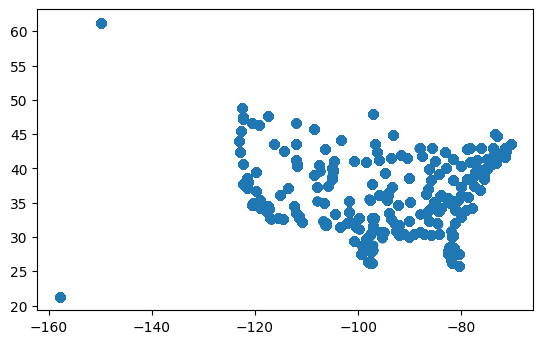

In [90]:
us_ice_office_points.plot()